In [10]:
import argparse
import gc
import logging
import os
import glob
import pandas as pd

import sys
# sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')


import time

from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
torch.backends.cudnn.benchmark = True

from matplotlib import pyplot as plt

from matplotlib import pyplot as plt
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
avm = ArgoverseMap()

num = 10

In [12]:
path = "/datasets/argoverse/forecasting_sample/data/"
dfs = [pd.read_csv(file) for file in  glob.glob(os.path.join(path, "*.csv"))]

In [119]:
df = dfs[0]
agent_df = df[df['OBJECT_TYPE'] == 'AGENT']
others_df = df[df['OBJECT_TYPE'] == 'OTHERS']
others_dfs = np.array([v for k, v in others_df.groupby('TRACK_ID')], dtype=object)
av_df = df[df['OBJECT_TYPE'] == 'AV']
agent_df['X'].values
df

,TIMESTAMP,TRACK_ID,OBJECT_TYPE,X,Y,CITY_NAME
0,3.159710e+08,00000000-0000-0000-0000-000000000000,AV,2169.596895,821.248774,PIT
1,3.159710e+08,00000000-0000-0000-0000-000000014129,OTHERS,2187.359738,840.592636,PIT
2,3.159710e+08,00000000-0000-0000-0000-000000014364,OTHERS,2181.477149,836.046175,PIT
3,3.159710e+08,00000000-0000-0000-0000-000000014617,OTHERS,2180.360176,827.757227,PIT
4,3.159710e+08,00000000-0000-0000-0000-000000014669,OTHERS,2176.596877,832.604432,PIT
...,...,...,...,...,...,...
924,3.159710e+08,00000000-0000-0000-0000-000000014692,OTHERS,2168.320631,826.459901,PIT
925,3.159710e+08,00000000-0000-0000-0000-000000014669,OTHERS,2175.172779,831.576875,PIT
926,3.159710e+08,00000000-0000-0000-0000-000000014818,OTHERS,2135.558555,815.385221,PIT
927,3.159710e+08,00000000-0000-0000-0000-000000014617,OTHERS,2180.051205,827.382011,PIT


In [62]:
import os
import sys
sys.path.append("../ddn/")
sys.path.append("./")
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import scipy.special
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from scipy.linalg import block_diag
from torch.utils.data import Dataset, DataLoader
#from bernstein import bernstesin_coeff_order10_new

from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
avm = ArgoverseMap()

def denoise(gt_x, gt_y, w = 7):
    # denoising
    gt_x_t = []
    gt_y_t = []
    for iq in range(len(gt_x)):
        if iq >= w and iq + w <= len(gt_x):
            gt_x_t.append(np.mean(gt_x[iq: iq + w]))
            gt_y_t.append(np.mean(gt_y[iq: iq + w]))
        elif iq < w:
            okx = np.mean(gt_x[w: w + w])
            gt_x_t.append(gt_x[0] + (okx - gt_x[0]) * (iq) / w)
            oky = np.mean(gt_y[w: w + w])
            gt_y_t.append(gt_y[0] + (oky - gt_y[0]) * (iq) / w)
        else:
            okx = np.mean(gt_x[len(gt_x) - w:len(gt_x) - w  + w])
            oky = np.mean(gt_y[len(gt_x) - w: len(gt_x) - w + w])
            gt_x_t.append(okx + (gt_x[-1] - okx) * (w - (len(gt_x) - iq)) / w)
            gt_y_t.append(oky + (gt_y[-1] - oky) * (w - (len(gt_y) - iq)) / w)                   

    gt_x = gt_x_t
    gt_y = gt_y_t
    return gt_x, gt_y

def rotate(gt_x, gt_y,theta):
    gt_x_x = [ (gt_x[k] * np.cos(theta) - gt_y[k] * np.sin(theta))  for k in range(len(gt_x))]
    gt_y_y = [ (gt_x[k] * np.sin(theta) + gt_y[k] * np.cos(theta))  for k in range(len(gt_x))]
    gt_x = gt_x_x
    gt_y = gt_y_y
    return gt_x, gt_y

def transform(x_traj, y_traj, dt = 0.3, t_obs = 20, theta=None, offsets=None):
    if offsets == None:
        x_traj -= x_traj[0]
        y_traj -= y_traj[0]
    else:
        x_traj -= offsets[0]
        y_traj -= offsets[1]
        
    gt_x = x_traj
    gt_y = y_traj
    
    gt_x, gt_y = denoise(gt_x, gt_y)
    v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
    v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
    psi = [ np.arctan2(v_y[k], v_x[k]) for k in range(len(v_x))]  

    # till here, gt-> (50, 1), v -> (49, 1), psi -> (31, 1)

    # obtain this -psi
    if theta == None:
        theta = -psi[t_obs - 1]

    # rotate by theta
    gt_x, gt_y = rotate(gt_x, gt_y, theta)
    v_x = [ (gt_x[k + 1] - gt_x[k])/dt  for k in range(len(gt_x) - 1)]
    v_y = [ (gt_y[k + 1] - gt_y[k])/dt  for k in range(len(gt_y) - 1)]
    psi = [ np.arctan2(v_y[k], v_x[k]) for k in range(len(v_x))]
    psidot = [ (psi[k + 1] - psi[k])/dt for k in range(len(psi) - 1) ]
    psi_traj = [i.item() for i in psi]
    psidot_traj = [i.item() for i in psidot]
    
    return gt_x, gt_y, v_x, v_y, psi, psidot, psi_traj, psidot_traj, theta

class ArgoverseDataset(Dataset):
    def __init__(self, data_path, t_obs=16, dt=0.125,centerline_dir=None, include_centerline = False, flatten=True):
        self.paths = glob.glob(os.path.join(path, "*.csv"))
        self.data_path = data_path
        self.t_obs = t_obs
        self.dt = dt
        self.include_centerline = include_centerline
        self.centerline_dir = centerline_dir
        self.flatten = flatten
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dt = self.dt
        path = self.paths[idx]
        df = pd.read_csv(path)
        agent_df = df[df['OBJECT_TYPE'] == 'AGENT']
        others_df = df[df['OBJECT_TYPE'] == 'OTHERS']
        others_dfs = np.array([v for k, v in others_df.groupby('TRACK_ID')], dtype=object)
        av_df = df[df['OBJECT_TYPE'] == 'AV']        

        x_traj = agent_df['X'].values
        y_traj = agent_df['Y'].values                

        # transformation
        x_traj, y_traj, v_x, v_y, psi, psi_dot, psi_traj, psidot_traj, theta = transform(x_traj, y_traj, dt = self.dt, t_obs = self.t_obs)                

        x_inp = x_traj[:self.t_obs]
        y_inp = y_traj[:self.t_obs]
        x_fut = x_traj[self.t_obs:]
        y_fut = y_traj[self.t_obs:]

        psi_fut = psi_traj[self.t_obs - 1:]
        psidot_fut = psi_traj[self.t_obs - 2:]
        
        vx_traj = v_x
        vy_traj = v_y
        
        vx_beg = vx_traj[self.t_obs]
        vy_beg = vy_traj[self.t_obs]
        
        vx_beg_prev = vx_traj[self.t_obs - 1]
        vy_beg_prev = vy_traj[self.t_obs - 1]
        
        ax_beg = (vx_beg - vx_beg_prev) / self.dt
        ay_beg = (vy_beg - vy_beg_prev) / self.dt

        vx_fin = v_x[-1]
        vy_fin = v_y[-1]
        
        vx_fin_prev = v_x[-2]
        vy_fin_prev = v_y[-2]

        ax_fin = (vx_fin - vx_fin_prev) / self.dt
        ay_fin = (vy_fin - vy_fin_prev) / self.dt

        x_fut = x_traj[self.t_obs:]
        y_fut = y_traj[self.t_obs:]
        
        if self.flatten:
            traj_inp = np.dstack((x_inp, y_inp)).flatten()  
        else:
            traj_inp = np.vstack((x_inp, y_inp))
            traj_inp = np.swapaxes(traj_inp, 0, 1)

        vx_fut = vx_traj[self.t_obs:]
        vy_fut = vy_traj[self.t_obs:]
        traj_out = np.hstack((x_fut, y_fut)).flatten()

        fixed_params = np.array([x_fut[0], y_fut[0], 0, psi_fut[0], psidot_fut[0]])
        var_inp = np.array([x_inp[-1], y_inp[-1], psi_fut[-1]])

        return torch.tensor(traj_inp), torch.tensor(traj_out), torch.tensor(fixed_params), torch.tensor(var_inp)

In [121]:
predictions = np.load('/home/vikrant/core/home/R/goal/code/prediction.npy', allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/vikrant/core/home/R/goal/code/prediction.npy'

In [122]:
gt = np.load('/datasets/argoverse/val_data.npy', allow_pickle=True)

In [32]:
train_dataset = ArgoverseDataset("/datasets/argoverse/forecasting_sample/data", t_obs=20, dt=0.3)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False, num_workers=0)

In [157]:
def vis_trajectories(data_path, output_dir="results/", dt = 0.3, t_obs=20, pred=False, pred_array=None, batch_size = 512):
    paths = glob.glob(os.path.join(data_path, "*.csv"))
    for idx in range(len(paths)):
        path = paths[idx]
        df = pd.read_csv(path)
        agent_df = df[df['OBJECT_TYPE'] == 'AGENT']
        others_df = df[df['OBJECT_TYPE'] == 'OTHERS']
        others_dfs = np.array([v for k, v in others_df.groupby('TRACK_ID')], dtype=object)
        av_df = df[df['OBJECT_TYPE'] == 'AV']
        city = df['CITY_NAME'].values[0]

        # agent
        x_traj = agent_df['X'].values
        y_traj = agent_df['Y'].values
        offsets = [x_traj[0], y_traj[0]] # offsets for other agents
#         x_traj, y_traj, v_x, v_y, psi, psi_dot, psi_traj, psidot_traj, theta_agent = transform(x_traj, y_traj)
        plt.figure(figsize=(15,15))

        plt.plot(x_traj[:t_obs], y_traj[:t_obs], color='blue', label='observed')
        plt.scatter(x_traj[t_obs], y_traj[t_obs], color='blue', label='end observed')
        plt.plot(x_traj[t_obs:], y_traj[t_obs:], color='orange', label='gt')
        plt.scatter(x_traj[-1], y_traj[-1], color='orange', label='gt end point')
        if pred:
            x_traj, y_traj, v_x, v_y, psi, psi_dot, psi_traj, psidot_traj, theta_agent = transform(x_traj, y_traj)
            pred_x = pred_array[idx][:, 0]
            pred_y = pred_array[idx][:, 1]
            pred_x, pred_y = rotate(pred_x, pred_y, -theta)
            pred_x += offsets[0]
            pred_y += offsets[1]
            plt.plot(pred_x, pred_y, color='orange', label='predicted')
            plt.scatter(pred_x[-1], pred_y[-1], color='orange', label='predicted goal point')    
    
        # av
        x_traj = av_df['X'].values
        y_traj = av_df['Y'].values
        plt.plot(x_traj, y_traj, color='red', label='AV')
        plt.scatter(x_traj[-1], y_traj[-1], color='red')
        
        # others
        for other in others_dfs:
            x_traj = other['X'].values
            y_traj = other['Y'].values
#             x_traj, y_traj, v_x, v_y, psi, psi_dot, psi_traj, psidot_traj, theta_others = transform(x_traj, y_traj, theta = theta_agent, offsets = offsets)
            plt.plot(x_traj, y_traj, color='grey')
            plt.scatter(x_traj[-1], y_traj[-1], color='grey')
        
        # centerlines
        lane_centerlines = []    
        # Get lane centerlines which lie within the range of trajectories
        agent_df = df[df['OBJECT_TYPE'] == 'AGENT']
        gt_x = agent_df['X'].values
        gt_y = agent_df['Y'].values
        
        x_max, y_max = np.max(gt_x) + 30, np.max(gt_y) + 30
        x_min, y_min = np.min(gt_x) - 30, np.min(gt_y) - 30
        
        print(x_max, x_min)
        print(y_max, y_min)

        avm = ArgoverseMap()
        seq_lane_props = avm.city_lane_centerlines_dict[city]
        for lane_id, lane_props in seq_lane_props.items():
            lane_cl = lane_props.centerline
            if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
                lane_centerlines.append(lane_cl)

        for lane_cl in lane_centerlines:
            plt.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)

        plt.legend()
        plt.axis('equal')
        plt.show()
        plt.savefig(output_dir + str(idx) + ".png")
        plt.clf()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

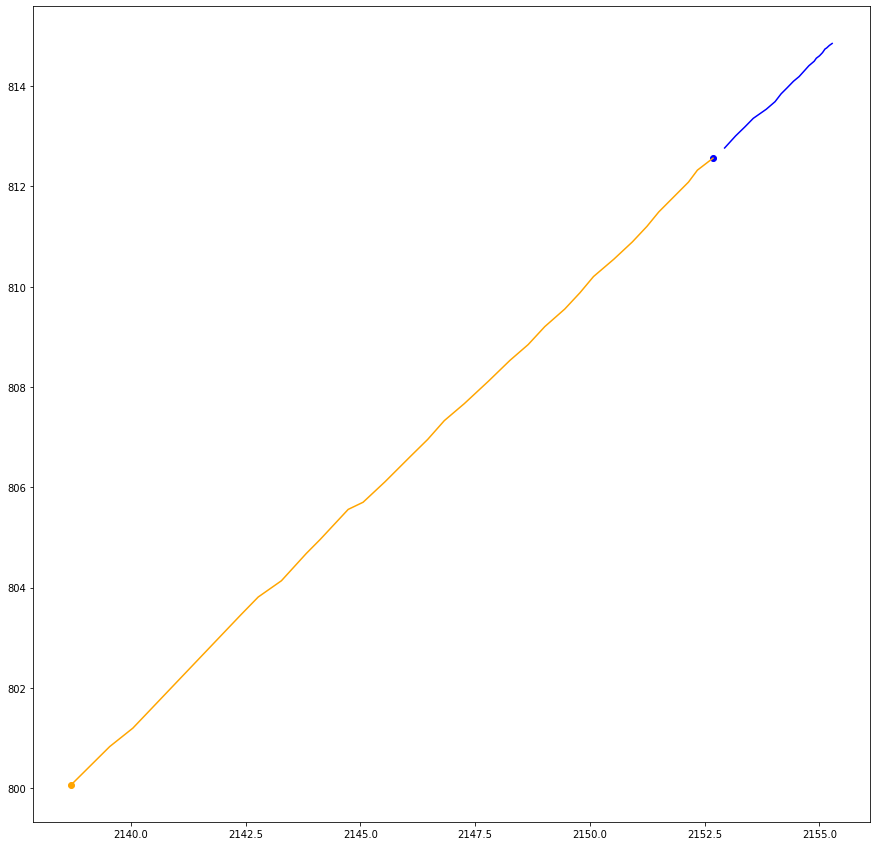

In [158]:
predictions = np.load('../prediction.npy', allow_pickle=True)
vis_trajectories(data_path = "/datasets/argoverse/forecasting_sample/data", output_dir="../results/", t_obs=20, pred=True, pred_array=predictions)

In [123]:
import pandas as pd
data_ = pd.read_pickle('/datasets/argoverse/forecasting_features_val.pkl')
features = data_["FEATURES"].values
features[0].shape

(50, 11)

2161.762974201896 2008.768453745044
714.6017919155471 574.1210947437952


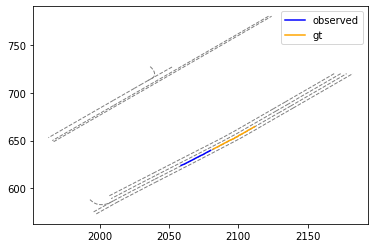

781.6266852083667 680.7826109429393
1523.9975028198678 1404.5526804618066


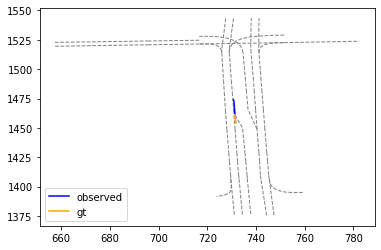

2237.6376249733357 2102.780535229472
774.4250305918488 648.9090198053317


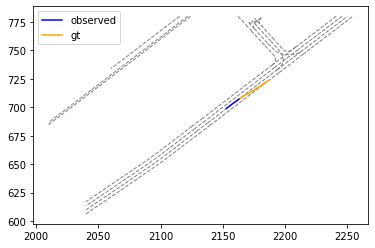

466.5951044828353 365.2773586469266
1211.8324819428942 1078.2040124501618


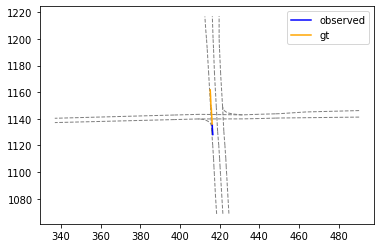

1952.8184857975425 1793.6434365311375
547.7488836779072 397.57938576292855


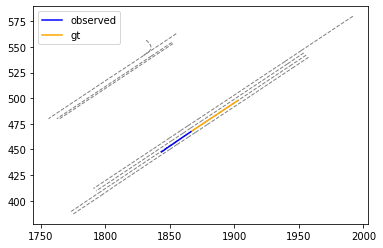

759.9163566123325 652.8559964299627
1220.3643021658604 1106.6889386431842


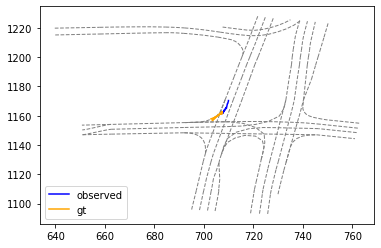

755.8450533318753 648.3600567871597
1206.3817571880638 1073.5248790579542


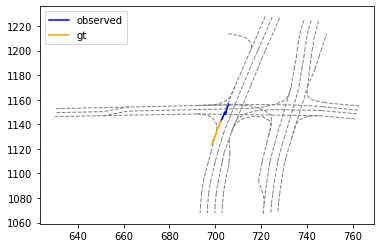

2042.5107036861664 1882.987372290088
625.9351804036646 480.0118602759792


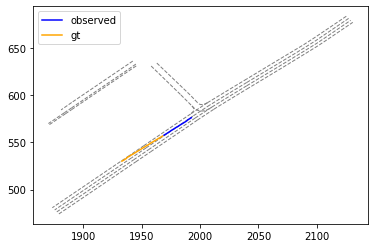

809.8252034016677 685.0127534127803
1438.5710944282987 1326.7616046079145


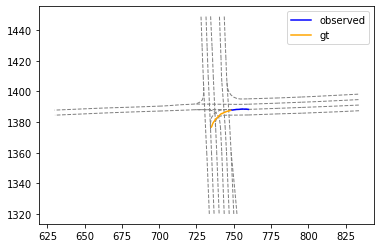

2083.1294074900725 1916.3254760561765
651.3785161570953 501.377264522731


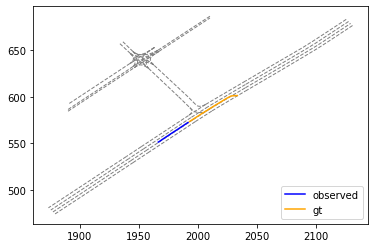

In [125]:
for i in range(num):
    city = features[i][0][5]
    seq_lane_props = avm.city_lane_centerlines_dict[city]
    
    gt_x = features[i][:, 3]
    gt_y = features[i][:, 4]
    
    x_max, y_max = np.max(gt_x) + 50, np.max(gt_y) + 50
    x_min, y_min = np.min(gt_x) - 50, np.min(gt_y) - 50
    print(x_max, x_min)
    print(y_max, y_min)
    
    lane_centerlines = []    
    # Get lane centerlines which lie within the range of trajectories
    for lane_id, lane_props in seq_lane_props.items():
        lane_cl = lane_props.centerline

        if (np.min(lane_cl[:, 0]) < x_max and np.min(lane_cl[:, 1]) < y_max and np.max(lane_cl[:, 0]) > x_min and np.max(lane_cl[:, 1]) > y_min):
            lane_centerlines.append(lane_cl)

    for lane_cl in lane_centerlines:
        plt.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)
    
    plt.plot(gt_x[:20], gt_y[:20], color='blue', label='observed')
    plt.plot(gt_x[20:], gt_y[20:], color='orange', label='gt')
#     plt.plot(pred_x[20:], pred_y[20:], color='red', label='predicted')
    plt.legend()
    plt.show()
    